In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

Momentum Model Rules Summary

* Trading is only done monthly
* Only stocks in the S&P 500 will be considered
* Momentum slope will be calculated using 125 days
* Top 30 stocks will be selected
* Weights will be calculated for these 30 stocks according to inverse volatility
* Volatility is calculated using 20 day standard deviation
* Trend filter calculated based on a 200 day average of the S&P 500 index
* If the trend filter is poisitive, we are allowed to buy
* Minimunm required momentum value is set to 40
* For each of the 30 selected stocks, if the stock has a momentum value higher than 40, we buy it. If not, we leave that calculated weight for that stock in cash
* We sell stocks if they fall below the minimum required momentum value, or if they leave the index
* Each month we rebalance and repeat

In [2]:
import zipline
from zipline.api import (
    order_target_percent,
    symbol,
    set_commission,
    set_slippage,
    schedule_function,
    date_rules,
    time_rules,
)
from datetime import datetime
import matplotlib.pyplot as plt
import pyfolio as pf
import pandas as pd
import numpy as np
from scipy import stats
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage

<IPython.core.display.Javascript object>

In [3]:
# Since we don't have real data on the components that make up the S&P 500...

from utils import generate_dummy_sp500_components

INDEX_DATA_PATH = "../../data/sp500.csv"
generate_dummy_sp500_components("1997-01-01", "2018-12-31").to_csv(INDEX_DATA_PATH)

<IPython.core.display.Javascript object>

In [4]:
# Global variables to control backtest

"""
Model Settings
"""
intial_portfolio = 10000000
momentum_window = 125
minimum_momentum = 40
portfolio_size = 30
vola_window = 20

"""
Commission and Slippage Settings
"""
enable_commission = True
commission_pct = 0.001
enable_slippage = True
slippage_volume_limit = 0.25
slippage_impact = 0.1

<IPython.core.display.Javascript object>

In [5]:
def momentum_score(ts):
    """
    Input:  Price time series.
    Output: Annualized exponential regression slope,
            multiplied by the R2
    """
    # Note I: The easiest way to calculate exponential regression is to just do
    # a linear regression based on the log values
    #
    # Note II: Idea behind exponential regression: https://rpubs.com/mengxu/exponential-model

    # Make a list of consecutive numbers
    x = np.arange(len(ts))
    # Get logs
    log_ts = np.log(ts)
    # Calculate regression values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)
    # Annualize percent
    annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100
    # Adjust for fitness
    score = annualized_slope * (r_value ** 2)
    return score

<IPython.core.display.Javascript object>

In [6]:
def volatility(ts):
    # vola_window is a global variable!
    return ts.pct_change().rolling(vola_window).std().iloc[-1]

<IPython.core.display.Javascript object>

In [7]:
def output_progress(context):
    """
    Output some performance numbers during backtest run
    This code just prints out the past month's performance
    so that we have something to look at while the backtest runs.
    """

    # Get today's date
    today = zipline.api.get_datetime().date()

    # Calculate percent difference since last month
    perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1

    # Print performance, format as percent with two decimals.
    print("{} - Last Month Result: {:.2%}".format(today, perf_pct))

    # Remember today's portfolio value for next month's calculation
    context.last_month = context.portfolio.portfolio_value

<IPython.core.display.Javascript object>

In [8]:
def initialize(context):

    # Set commission and slippage.
    if enable_commission:
        comm_model = PerDollar(cost=commission_pct)
    else:
        comm_model = PerDollar(cost=0.0)
    set_commission(comm_model)

    if enable_slippage:
        slippage_model = VolumeShareSlippage(
            volume_limit=slippage_volume_limit, price_impact=slippage_impact
        )
    else:
        slippage_model = FixedSlippage(spread=0.0)
    set_slippage(slippage_model)

    # Used only for progress output.
    context.last_month = intial_portfolio

    # Fetch and store index membership
    context.index_members = pd.read_csv(INDEX_DATA_PATH, index_col=0, parse_dates=[0])

    # Schedule rebalance monthly.
    schedule_function(
        func=rebalance,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open(),
    )

<IPython.core.display.Javascript object>

In [9]:
def rebalance(context, data):
    # Write some progress output during the backtest
    output_progress(context)

    # Ok, let's find which stocks can be traded today.

    # First, get today's date
    today = zipline.api.get_datetime()

    # Second, get the index makeup for all days prior to today.
    all_prior = context.index_members.loc[context.index_members.index < today]

    # Now let's snag the first column of the last, i.e. latest, entry.
    latest_day = all_prior.iloc[-1, 0]

    # Split the text string with tickers into a list
    list_of_tickers = latest_day.split(",")

    # Finally, get the Zipline symbols for the tickers
    todays_universe = [symbol(ticker) for ticker in list_of_tickers]

    # There's your daily universe. But we could of course have done this in one go.
    """       
    
    # This line below does the same thing,
    # using the same logic to fetch today's stocks.
    
    todays_universe = [
        symbol(ticker) for ticker in 
        context.index_members.loc[context.index_members.index < today].iloc[-1,0].split(',')
    ]
    """

    # Get historical data
    hist = data.history(todays_universe, "close", momentum_window, "1d")

    # Make momentum ranking table
    ranking_table = hist.apply(momentum_score).sort_values(ascending=False)

    """
    Sell Logic
    
    First we check if any existing position should be sold.
    * Sell if stock is no longer part of index.
    * Sell if stock has too low momentum value.
    """
    kept_positions = list(context.portfolio.positions.keys())
    for security in context.portfolio.positions:
        if security not in todays_universe:
            order_target_percent(security, 0.0)
            kept_positions.remove(security)
        elif ranking_table[security] < minimum_momentum:
            order_target_percent(security, 0.0)
            kept_positions.remove(security)

    """
    Stock Selection Logic
    
    Check how many stocks we are keeping from last month.
    Fill from top of ranking list, until we reach the
    desired total number of portfolio holdings.
    """
    replacement_stocks = portfolio_size - len(kept_positions)
    buy_list = ranking_table.loc[~ranking_table.index.isin(kept_positions)][
        :replacement_stocks
    ]

    new_portfolio = pd.concat(
        (buy_list, ranking_table.loc[ranking_table.index.isin(kept_positions)])
    )

    """
    Calculate inverse volatility for stocks, 
    and make target position weights.
    """
    vola_table = hist[new_portfolio.index].apply(volatility)
    inv_vola_table = 1 / vola_table
    sum_inv_vola = np.sum(inv_vola_table)
    vola_target_weights = inv_vola_table / sum_inv_vola

    for security, rank in new_portfolio.iteritems():
        weight = vola_target_weights[security]
        if security in kept_positions:
            order_target_percent(security, weight)
        else:
            if ranking_table[security] > minimum_momentum:
                order_target_percent(security, weight)

<IPython.core.display.Javascript object>

In [10]:
def analyze(context, perf):

    perf["max"] = perf.portfolio_value.cummax()
    perf["dd"] = (perf.portfolio_value / perf["max"]) - 1
    maxdd = perf["dd"].min()

    ann_ret = (
        np.power(
            (perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),
            (252 / len(perf)),
        )
    ) - 1

    print("Annualized Return: {:.2%} Max Drawdown: {:.2%}".format(ann_ret, maxdd))

    return

<IPython.core.display.Javascript object>

In [11]:
start = pd.Timestamp("1997-01-01 8:15:12", tz="UTC")
end = pd.Timestamp("2017-11-30 8:15:12", tz="UTC")

<IPython.core.display.Javascript object>

In [12]:
%%time
perf = zipline.run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    analyze=analyze,
    capital_base=intial_portfolio,
    data_frequency="daily",
    bundle="quandl",  # bundle used in the book was "ac_equities_db"
)

1997-01-02 - Last Month Result: 0.00%
1997-02-03 - Last Month Result: 2.69%
1997-03-03 - Last Month Result: 0.85%
1997-04-01 - Last Month Result: -2.62%
1997-05-01 - Last Month Result: 2.24%
1997-06-02 - Last Month Result: 1.51%
1997-07-01 - Last Month Result: 1.30%
1997-08-01 - Last Month Result: 1.70%
1997-09-02 - Last Month Result: -2.01%
1997-10-01 - Last Month Result: -0.04%
1997-11-03 - Last Month Result: -0.67%
1997-12-01 - Last Month Result: -0.51%
1998-01-02 - Last Month Result: -0.10%
1998-02-02 - Last Month Result: 0.80%
1998-03-02 - Last Month Result: -0.01%
1998-04-01 - Last Month Result: 0.81%
1998-05-01 - Last Month Result: -0.45%
1998-06-01 - Last Month Result: -0.58%
1998-07-01 - Last Month Result: 3.62%
1998-08-03 - Last Month Result: -0.30%
1998-09-01 - Last Month Result: -4.87%
1998-10-01 - Last Month Result: 0.23%
1998-11-02 - Last Month Result: 1.80%
1998-12-01 - Last Month Result: -0.10%
1999-01-04 - Last Month Result: 0.77%
1999-02-01 - Last Month Result: 1.53%


2014-11-03 - Last Month Result: 1.04%
2014-12-01 - Last Month Result: 0.39%
2015-01-02 - Last Month Result: -0.28%
2015-02-02 - Last Month Result: 0.23%
2015-03-02 - Last Month Result: 1.40%
2015-04-01 - Last Month Result: -0.56%
2015-05-01 - Last Month Result: -0.00%
2015-06-01 - Last Month Result: 0.12%
2015-07-01 - Last Month Result: 0.29%
2015-08-03 - Last Month Result: 0.04%
2015-09-01 - Last Month Result: -0.65%
2015-10-01 - Last Month Result: 0.13%
2015-11-02 - Last Month Result: 0.00%
2015-12-01 - Last Month Result: 0.06%
2016-01-04 - Last Month Result: -0.18%
2016-02-01 - Last Month Result: -0.05%
2016-03-01 - Last Month Result: -0.48%
2016-04-01 - Last Month Result: 0.31%
2016-05-02 - Last Month Result: -0.29%
2016-06-01 - Last Month Result: 0.09%
2016-07-01 - Last Month Result: 0.04%
2016-08-01 - Last Month Result: 0.25%
2016-09-01 - Last Month Result: -0.42%
2016-10-03 - Last Month Result: 0.01%
2016-11-01 - Last Month Result: -0.22%
2016-12-01 - Last Month Result: 0.57%
20

<IPython.core.display.Javascript object>

Start date,1997-01-02
End date,2017-11-30
Total months,250
,Backtest
Annual return,1.7%
Cumulative returns,41.6%
Annual volatility,4.1%
Sharpe ratio,0.42
Calmar ratio,0.19
Stability,0.91
Max drawdown,-8.8%


/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.81,1998-07-17,1998-08-31,1999-04-09,191
1,6.84,2000-03-23,2003-01-27,2005-02-04,1272
2,6.31,2007-02-21,2009-07-07,2009-09-09,666
3,5.71,1997-07-28,1997-10-27,1998-06-29,241
4,5.06,1997-02-13,1997-04-11,1997-06-06,82


/usr/local/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute 

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)
/usr/local/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
Th

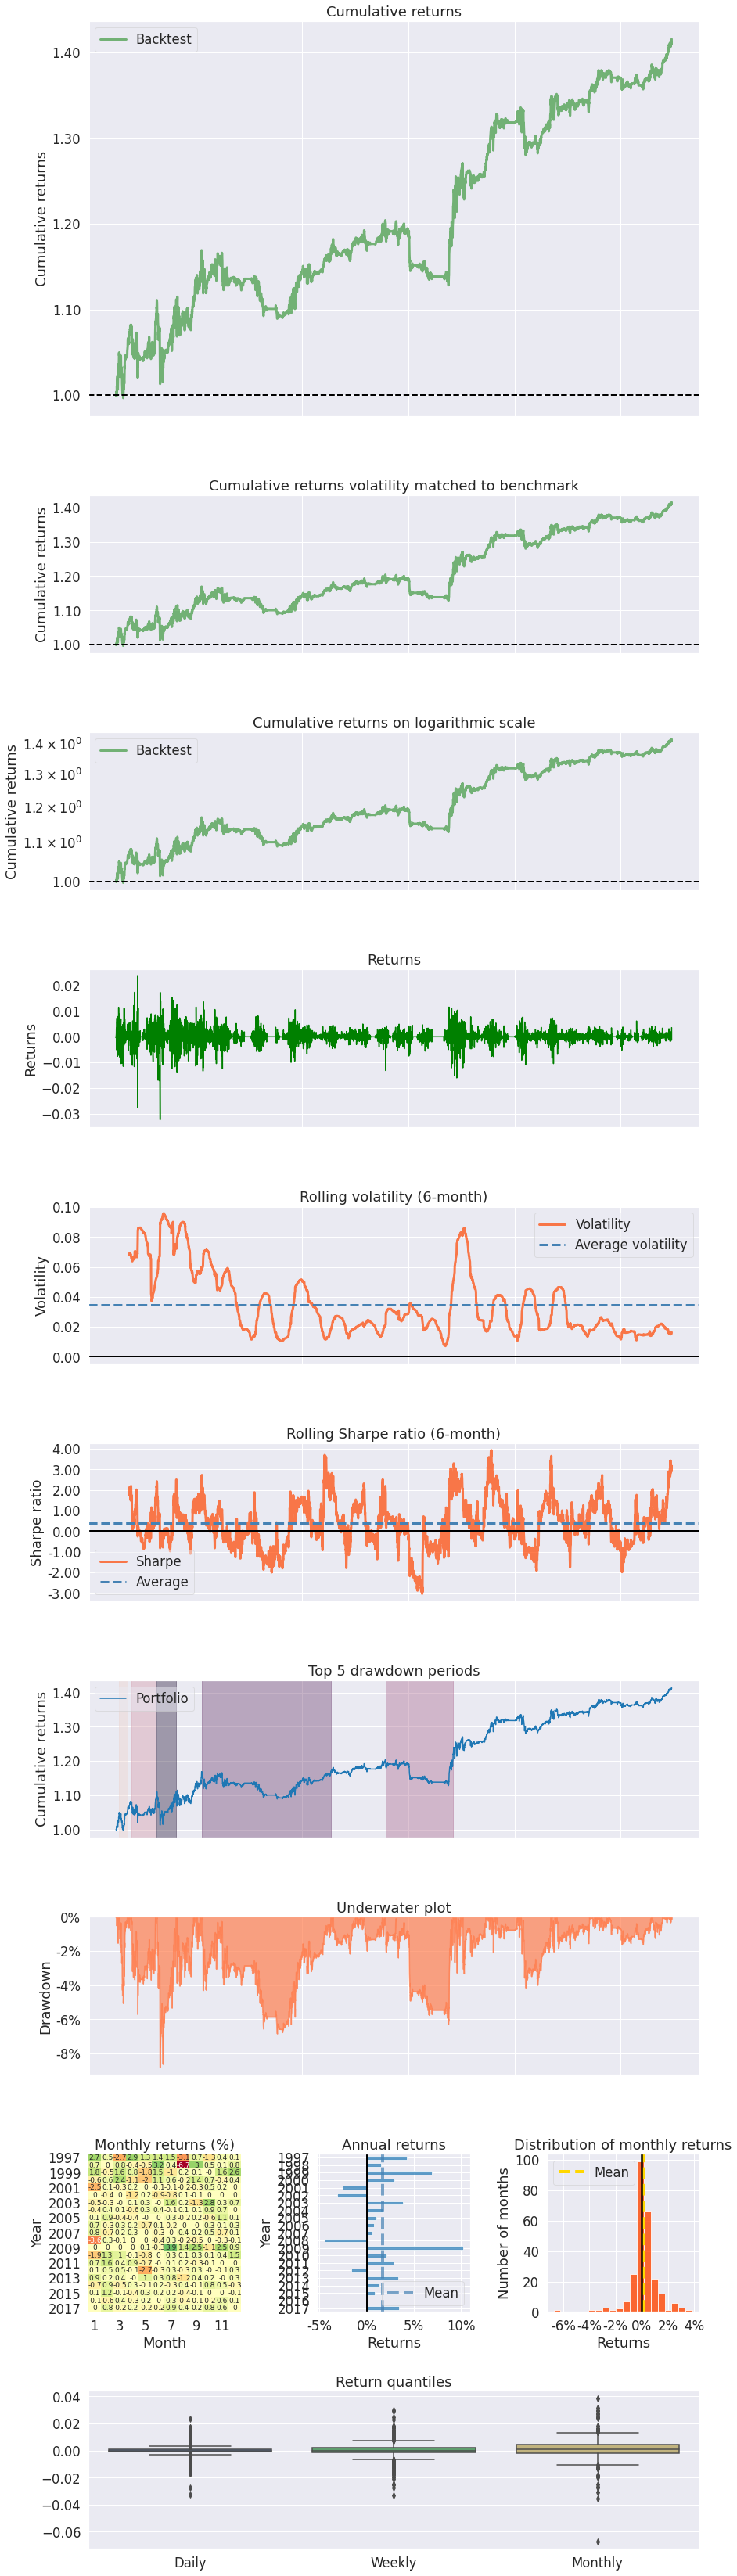

<IPython.core.display.Javascript object>

In [13]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
pf.create_returns_tear_sheet(returns, benchmark_rets=None)